<a href="https://colab.research.google.com/github/rhysdavies21/library/blob/master/rate_derivatives.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ZC Bond Calculator

def zero_coupon_bond(par, y, t):
  '''
  Price of a zero coupon bond
  
  : param par: face value of bond
  : param y: annual yield or rate of the bond:
  : param t: time to maturity, in years
  '''
  return par / (1+y)**t

In [ ]:
# Price ZC Bond

print(zero_coupon_bond(100, 0.05, 5))

78.35261664684589


In [16]:
# Bootstrapping yield curve

import math

class BootstrapYieldCurve(object):

  def __init__(self):
    self.zero_rates = dict()
    self.instruments = dict()

  def add_instrument(self, par, T, coup, price, compounding_freq=2):
    self.instruments[T] = (par, coup, price, compounding_freq)

  def get_maturities(self):
    '''
    : return: a list of maturities of added instruments
    '''
    return sorted(self.instruments.keys())

  def get_zero_rates(self):
    '''
    Returns a list of spot rates on the yield curve
    '''
    self.bootstrap_zero_coupons()
    self.get_bond_spot_rates()
    return [self.zero_rates[T] for T in self.get_maturities()]

  def bootstrap_zero_coupons(self):
    '''
    Bootstrap the yield curve with zero coupon instruments first
    '''
    for (T, instrument) in self.instruments.items():
      (par, coup, price, freq) = instrument
      if coup == 0:
        spot_rate = self.zero_coupon_spot_rate(par, price, T)
        self.zero_rates[T] = spot_rate

  def zero_coupon_spot_rate(self, par, price, T):
    '''
    : return: the zero coupon spot rate with continuous compounding
    '''
    spot_rate = math.log(par/price)/T
    return spot_rate
  
  def get_bond_spot_rates(self):
    '''
    Get spot rates implied by bonds, using short-term instruments
    '''
    for T in self.get_maturities():
      instrument = self.instruments[T]
      (par, coup, price, freq) = instrument
      if coup != 0:
        spot_rate = self.calculate_bond_spot_rate(T, instrument)
        self.zero_rates[T] = spot_rate

  def calculate_bond_spot_rate(self, T, instrument):
    try: 
      (par, coup, price, freq) = instrument
      periods = T* freq
      value = price
      per_coupon = coup/freq
      for i in range (int(periods)-1):
        t = (i+1)/float(freq)
        spot_rate = self.zero_rates[t]
        discounted_coupon = per_coupon * math.exp(-spot_rate * t)
        value -= discounted_coupon

      last_period = int(periods)/float(freq)
      spot_rate = - math.log(value/(par + per_coupon)) / last_period
      return spot_rate
    except:
      print('Error: spot rate note found for T=', t)

Populating the interactive namespace from numpy and matplotlib


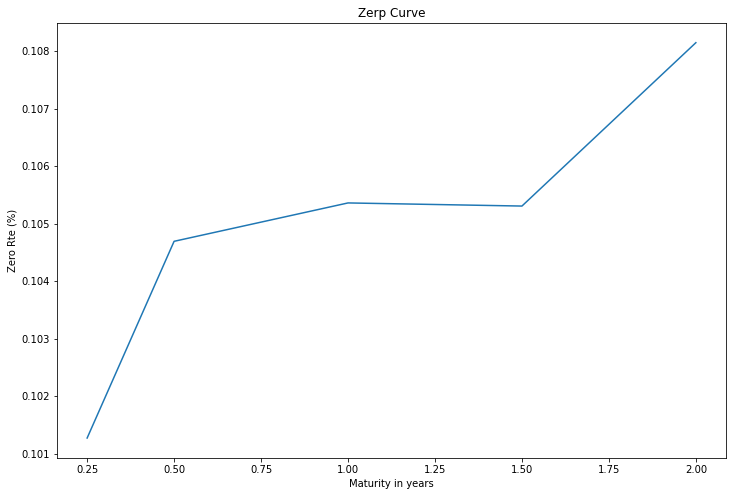

In [17]:
# Instantiate BootstrapYieldCurve

yield_curve = BootstrapYieldCurve()
yield_curve.add_instrument(100, 0.25, 0., 97.5)
yield_curve.add_instrument(100, 0.5, 0., 94.9)
yield_curve.add_instrument(100, 1.0, 0., 90.)
yield_curve.add_instrument(100, 1.5, 8, 96.2, 2)
yield_curve.add_instrument(100, 2.0, 12, 101.6, 2)

y = yield_curve.get_zero_rates()
x = yield_curve.get_maturities()

%pylab inline

fig = plt.figure(figsize=(12,8))
plot(x, y)
title('Zerp Curve')
ylabel('Zero Rte (%)')
xlabel('Maturity in years');